## Conditional Convolutional Variational Autoencoder

Some references:
- https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/
- https://github.com/lyeoni/keras-mnist-CVAE/blob/master/keras-mnist-CVAE.ipynb

In [1]:
# disable GPU
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import tensorflow as tf
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
from tensorflow import keras as keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Concatenate

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
oh_encoder = OneHotEncoder(categories='auto', sparse=False)
y_train_oh = oh_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_oh = oh_encoder.transform(y_test.reshape(-1, 1))
x_train_3d = np.reshape(x_train, (x_train.shape[0], 28, 28, 1))
x_test_3d = np.reshape(x_test, (x_test.shape[0], 28, 28, 1))

In [4]:
x_train_3d.shape

(60000, 28, 28, 1)

In [5]:
n_batch = 50
n_classes = y_train_oh.shape[1]
n_latent = 2
n_channels = 1
n_epoch = 20

In [6]:
def sample_z(args):
    mu, log_var = args
    batch = K.shape(mu)[0]
    eps = K.random_normal(shape=(batch, n_latent))
    return mu + K.exp(log_var / 2) * eps


#### encoder

In [7]:
input_image = Input(shape=(28,28,1,))
input_cond = Input(shape=(n_classes,))

x = Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME")(input_image)
x = Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME")(x)
x = Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME")(x)
n_x_conv = x.shape
x = Flatten()(x)
n_x_flattened = x.shape[1]
x = Dense(64, activation='relu')(x)
x = Dense(n_latent, activation='relu')(x)
x_encoded = Dense(n_latent, activation='relu')(x)
mu = Dense(n_latent, activation='linear')(x_encoded)
log_var = Dense(n_latent, activation='linear')(x_encoded)
# encoder sampler
z = Lambda(sample_z, output_shape=(n_latent,))([mu, log_var])
z_cond = Concatenate(axis=-1)([z, input_cond])

#### decoder


In [8]:
z_in = Input(shape=(n_latent,))
cond_in = Input(shape=(n_classes,))
dec_input = Concatenate(axis=1)([z_in, cond_in])
dec = Dense(n_latent, activation='relu')(dec_input)
dec = Dense(64, activation='relu')(dec)
dec = Dense(n_x_flattened, activation='relu')(dec)
dec = Reshape(tuple(n_x_conv[1:]))(dec)
dec = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME", output_padding=0)(dec)
dec = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME")(dec)
x_out = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME")(dec)

In [9]:
encoder = Model([input_image, input_cond], [mu, log_var, z, input_cond])
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 4, 32)     18464       conv2d_1[0][0]                   
______________________________________________________________________________________________

In [10]:
decoder =  Model([z_in, cond_in], x_out)
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 12)           0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 2)            26          concatenate_1[0][0]        

In [11]:
output = decoder(encoder([[input_image, input_cond]])[2:])

In [12]:
# loss
reconstruction_loss = keras.losses.binary_crossentropy(keras.layers.Flatten()(input_image), 
                                                       keras.layers.Flatten()(output)) * 28**2
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
cvae_loss = reconstruction_loss + kl_loss

cvae = Model([input_image, input_cond], output)
cvae.add_loss(cvae_loss)
cvae.compile(optimizer='adam')
cvae.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_2:0
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 2), (None, 2 70260       input_1[0][0]                    
                                                                 input_2[0][0]                    
________________________________________________________________

In [13]:
# train
cvae.fit([x_train_3d, y_train_oh],
       shuffle=True,
       epochs=50,
       batch_size=50,
       validation_data=([x_test_3d, y_test_oh], None), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 184us/sample - loss: 201.3505 - val_loss: 177.0887
Epoch 2/50
60000/60000 [==============================] - 8s 130us/sample - loss: 171.5023 - val_loss: 165.3645
Epoch 3/50
60000/60000 [==============================] - 8s 131us/sample - loss: 166.1583 - val_loss: 161.6774
Epoch 4/50
60000/60000 [==============================] - 8s 131us/sample - loss: 163.2273 - val_loss: 160.7408
Epoch 5/50
60000/60000 [==============================] - 8s 130us/sample - loss: 159.3472 - val_loss: 159.3189
Epoch 6/50
60000/60000 [==============================] - 8s 131us/sample - loss: 159.1530 - val_loss: 156.7161
Epoch 7/50
60000/60000 [==============================] - 8s 131us/sample - loss: 157.1907 - val_loss: 155.4015
Epoch 8/50
60000/60000 [==============================] - 8s 131us/sample - loss: 156.1383 - val_loss: 154.7069
Epoch 9/50
60000/60000 [=============================

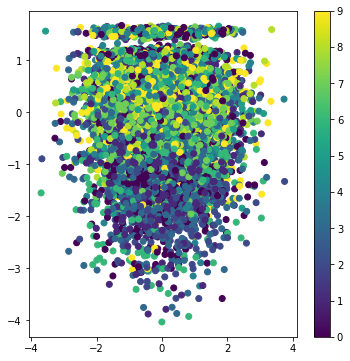

In [14]:
# Plot of the digit classes in the latent space
te_latent = encoder.predict(
    [x_test_3d, y_test_oh], 
    batch_size=50)

pred_mu, pred_var, pred_z, pred_cond = te_latent[0], te_latent[1], te_latent[2], te_latent[3]

plt.figure(figsize=(6, 6))
plt.scatter(pred_z[:, 0], pred_z[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [15]:
def to_categorical(num):
    return oh_encoder.transform([[num]])[0]

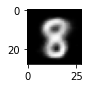

In [17]:
num_class = 8
pred_class = np.array(oh_encoder.transform([[num_class]]))
pred_noise = np.random.randn(1, n_latent)
pred_out = decoder.predict([pred_noise, pred_class])
plt.figure(figsize = (1,1))
plt.imshow(pred_out[0,:,:, 0], cmap='Greys_r',)

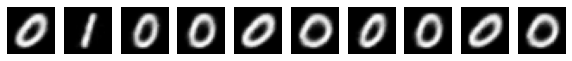

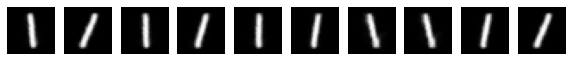

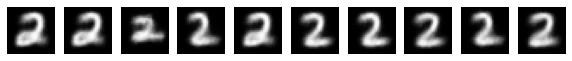

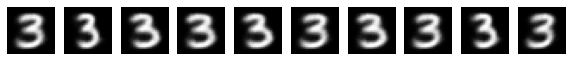

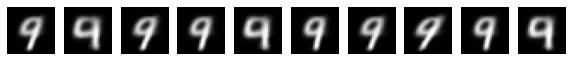

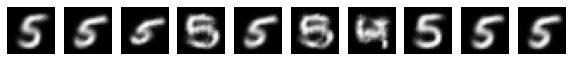

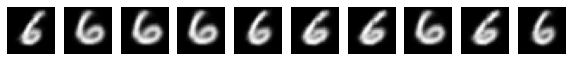

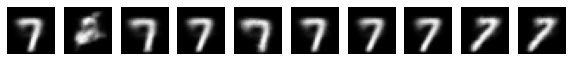

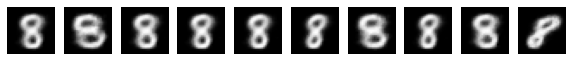

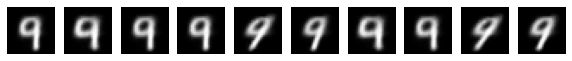

In [18]:
digit_size = 28
for cond_num in range(10):
    condition_num = np.array([to_categorical(cond_num)])
    plt.figure(figsize=(10, 1))

    for i in range(10):
        z_sample = np.random.randn(1,n_latent)
        x_decoded = decoder.predict([z_sample, condition_num])
        digit = x_decoded[0].reshape(digit_size, digit_size)

        plt.subplot(1, 10, i+1)
        plt.axis('off')
        plt.imshow(digit, cmap='Greys_r',)

plt.show()
